In [67]:
import sys
sys.path.append('../')
import potentials


In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import pickle
import pandas as pd
from itertools import product as prod
import proplot as pplt
from scipy.special import expit
from tqdm import tqdm
import itertools as it
import scipy
from scipy.sparse import linalg as splinalg
import scipy.sparse as sparse
import sys
from sksparse.cholmod import cholesky

nr, nc = 128, 256

np.random.seed(110104)
plt.rc("text", usetex=True)

In [69]:
# Z = potentials.sample_gp2d(nr // 4 + 1, nc // 4 + 1, b=0.25)
# Z2 = potentials.up(Z, factor=2)
ksize = 13
nr, nc = 128, 256
U, V, P, L = potentials.potential_features(nr, nc, ksize)

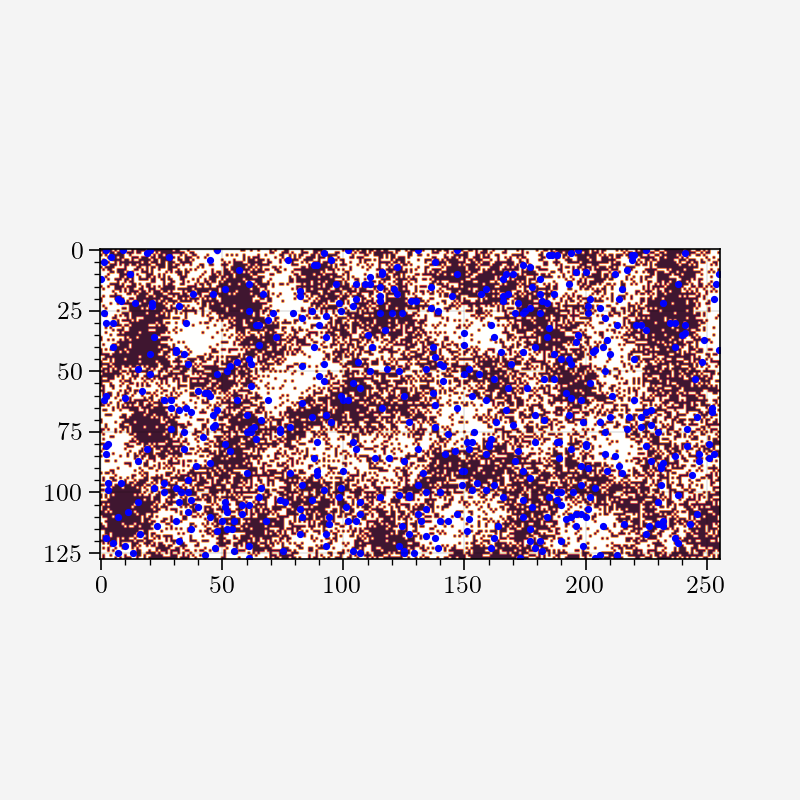

In [70]:
# sample from a bernoulli for each pixel in L with probability sigmoid(L)
logits = (L - L.mean()) / L.std()
A = np.random.rand(*L.shape) < expit(logits)

# choose 500 points at random
N = 500
mask = np.zeros((nr * nc, ), dtype=bool)
idx = np.random.choice(np.arange(nr * nc), N, replace=False)
mask[idx] = True
mask = mask.reshape(nr, nc)

plt.imshow(A)
x, y = np.where(mask)
plt.scatter(y, x, s=4, c="blue")

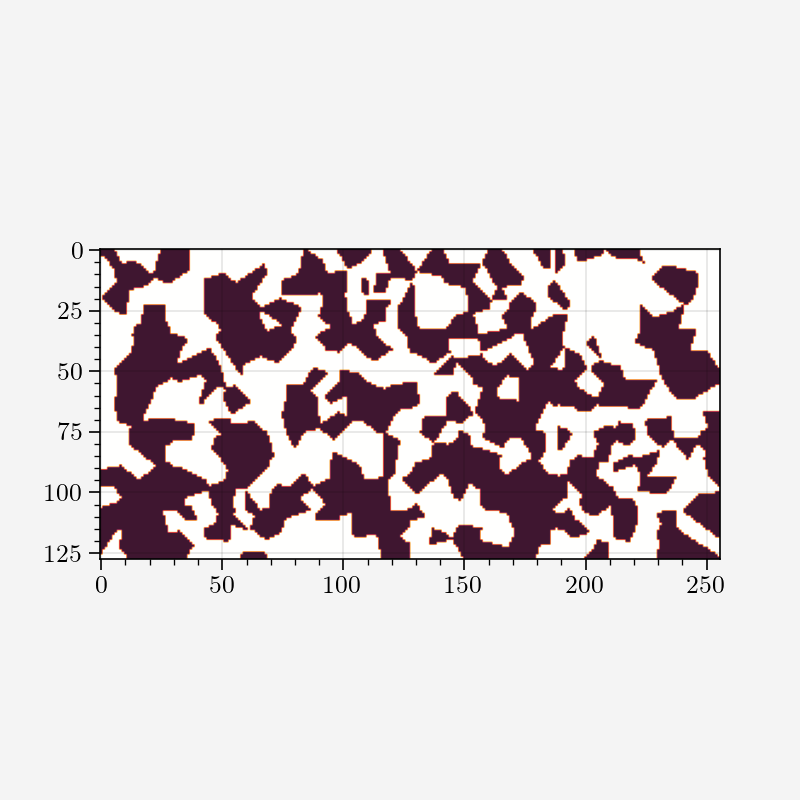

In [71]:
sample_list = np.stack([x, y], axis=1)
X, Y = np.meshgrid(np.arange(nc), np.arange(nr))
arr = np.stack([Y.flatten(), X.flatten()], axis=1)
closest = np.argmin(np.linalg.norm(arr[:, None] - sample_list[None], axis=2), axis=1)
ix = sample_list[closest]
ix = ix[:, 0], ix[:, 1]
nn = np.zeros((nr, nc), dtype=bool)
nn[Y.flatten(), X.flatten()] = A[ix]
# for i in tqdm(range(nr)):
#     for j in range(nc):
#         cell = np.array([[i, j]])
#         dists = np.linalg.norm(sample_list - cell, axis=1)
#         nni, nnj = sample_list[np.argmin(dists)]
#         nn[i, j] = A[nni, nnj]
plt.imshow(nn)

100%|██████████| 128/128 [00:02<00:00, 57.25it/s]


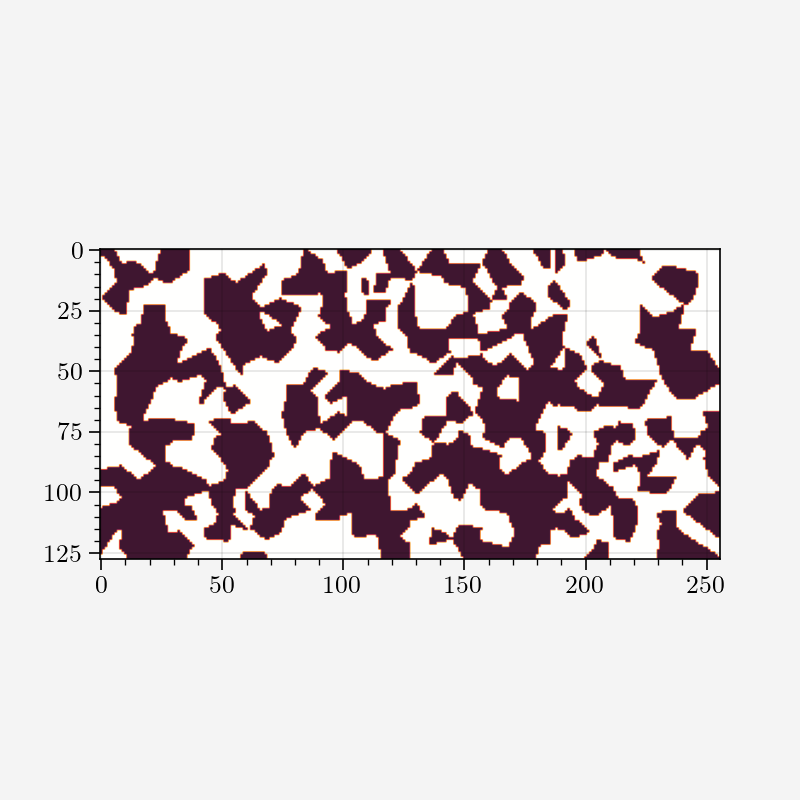

In [72]:
sample_list = np.stack([x, y], axis=1)
nn = np.zeros((nr, nc), dtype=bool)
for i in tqdm(range(nr)):
    for j in range(nc):
        cell = np.array([[i, j]])
        dists = np.linalg.norm(sample_list - cell, axis=1)
        nni, nnj = sample_list[np.argmin(dists)]
        nn[i, j] = A[nni, nnj]
plt.imshow(nn)

In [73]:
import networkx as nx
# edgelist = []
# for i in range(nr):
#     for j in range(nc):
#         if i > 0:
#             edgelist.append(((i, j), (i - 1, j)))
#         if i < nr - 1:
#             edgelist.append(((i, j), (i + 1, j)))
#         if j > 0:
#             edgelist.append(((i, j), (i, j - 1)))
#         if j < nc - 1:
#             edgelist.append(((i, j), (i, j + 1)))
# G = nx.Graph(edgelist)
G = nx.grid_2d_graph(nr, nc)

In [74]:
nodes = [tuple(arr[i]) for i in range(arr.shape[0])]
pair2node = {tuple(n): i for i, n in enumerate(nodes)}
lam = 1.0
Q = lam * nx.laplacian_matrix(G, nodes).transpose()
obs_nodes = [pair2node[xi, yi] for xi, yi in zip(x, y)]
for i in obs_nodes:
    Q[i, i] += 1.0
# Q[np.diag_indices_from(Q)] += 1.0
Q

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


<32768x32768 sparse matrix of type '<class 'numpy.float64'>'
	with 163072 stored elements in Compressed Sparse Column format>

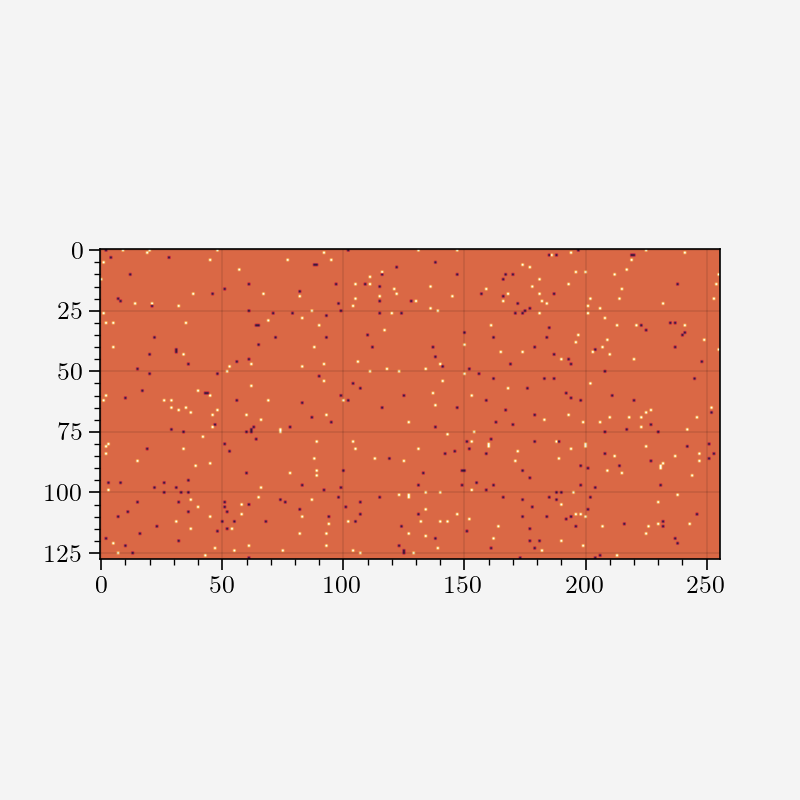

In [75]:
Y = np.zeros((nr, nc))
Y[x, y] = 10.0 * (A[x, y] - 0.5)
plt.imshow(Y)

In [76]:
# LU = splinalg.splu(Q, diag_pivot_thresh=0) 
# Chol = LU.L.dot( sparse.diags(LU.U.diagonal()**0.5) )
# n = Q.shape[0]
# Pr = sparse.csc_matrix((np.ones(n), (LU.perm_r, np.arange(n))))
# Pc = sparse.csc_matrix((np.ones(n), (np.arange(n), LU.perm_c)))
# Qrec = LU.L @ LU.U
# Q0 = Pr @ Q @ Pc
ch = cholesky(Q)

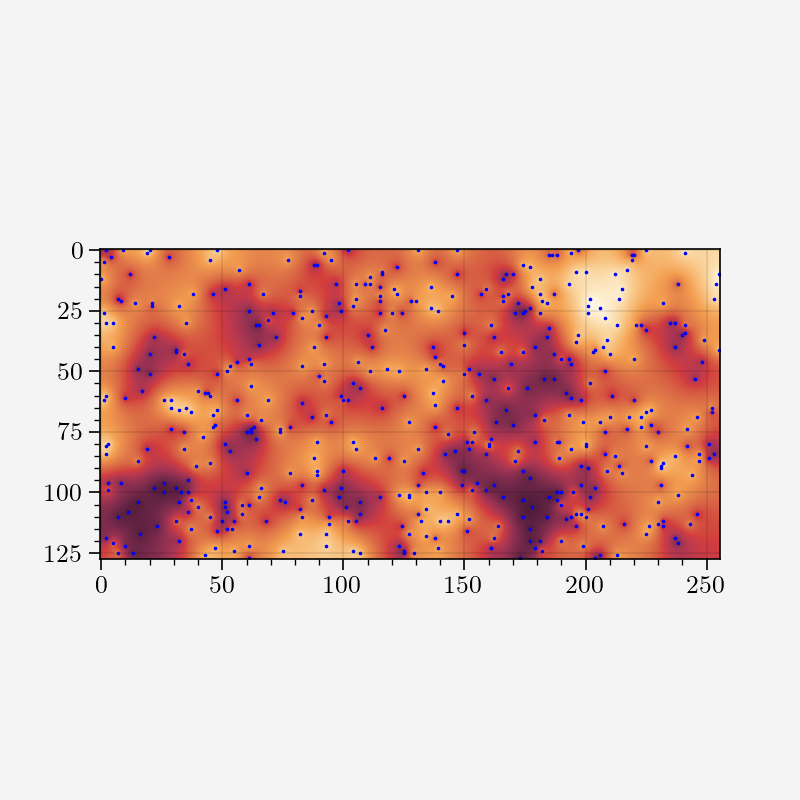

In [77]:
Yflat = Y[arr[:, 0], arr[:, 1]]
# Yhat = LU.solve(Yflat)
Yhat = ch.solve_A(Yflat).reshape(nr, nc)
plt.imshow(Yhat)
plt.scatter(y, x, s=0.5, c="blue")

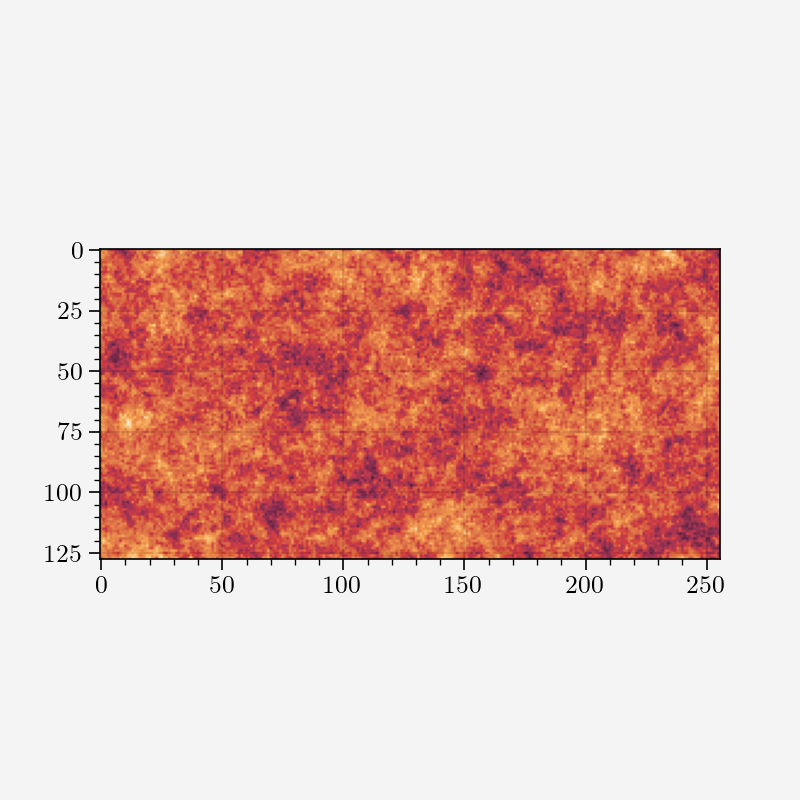

In [78]:
n = nr * nc
eps = np.random.randn(n)
P = sparse.csc_matrix((np.ones(n), (ch.P(), np.arange(n))))
# Z1 = ch.solve_Lt(eps, False)[np.argsort(ch.P())].reshape(nr, nc)
Z2 = P @ ch.solve_Lt(eps, False)
# Z1 = Z1.reshape(nr, nc)
Z2 = Z2.reshape(nr, nc)
plt.imshow(Z2)
# plt.imshow(Yhat + Z > 0.0)